## EDA Sub Samples Daily

Note: the energy consumption prediction will be transfromed from time-series data model into tabular data model

In [95]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.getcwd() + "/..")
from utils import plot_correlogram, combine_data
from data_processing import DataProcessAggregateDaily
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [2]:
meta, data =pd.read_pickle("../data/forecast_data_2020.p")

In [3]:
homes_indexes = data.columns.get_level_values(0).unique()

In [4]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

## Transform Data

In [5]:
obj = DataProcessAggregateDaily(data,meta)
data_prepocessed = obj.main()

In [42]:
# for key, val in data_prepocessed.items():
#     print(f"home {key}: {val.shape}")

In [7]:
full_data = combine_data(data_prepocessed)

In [8]:
full_data.columns

Index(['consumption_(t+1)', 'consumption_(t-1)', 'avg_temperature',
       'min_temperature', 'max_temperature', 'spread_temperature',
       'avg_humidity', 'min_humidity', 'max_humidity', 'spread_humidity',
       'avg_cloudiness', 'min_cloudiness', 'max_cloudiness',
       'spread_cloudiness', 'ev', 'home_num'],
      dtype='object')

In [73]:
target_name = "consumption_(t+1)"

# will use all data
feature_name = full_data.columns
X, y = full_data[feature_name], full_data[[target_name]+["home_num"]]

# NOTE: we shuffle the data instead of using time_series split/validation sets..
# X_train, _, y_train, _ = train_test_split( X, y, test_size=0.3, random_state=random_state, shuffle=True)
homes_indexes = np.random.choice(list(data_prepocessed.keys()), 80, replace=False)
X_train, y_train = X[X["home_num"].isin(homes_indexes)], y[y["home_num"].isin(homes_indexes)]
y_train.drop("home_num", axis = 1, inplace=True)

## EDA Univariate Target

###  Distribution

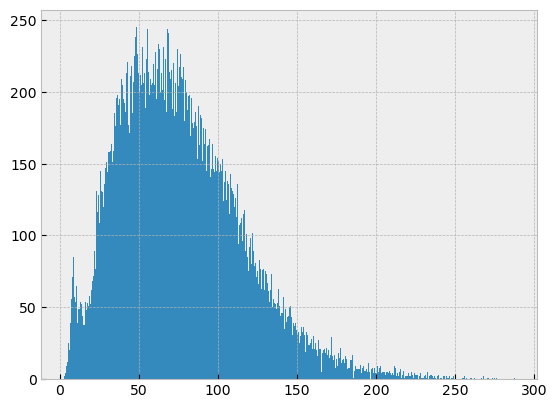

In [75]:
plt.hist(X[target_name], bins = 500)
plt.show()

In [76]:
stats.kstest(X[target_name], stats.norm.cdf)

KstestResult(statistic=0.9997843816848191, pvalue=0.0)

1) Target variable does not appear to be Normally Distributed
2) we have right skewed distribution of target thus for GLM we should use LOG transformation or Poisson Regression) 

### Target Distribution hue with EV

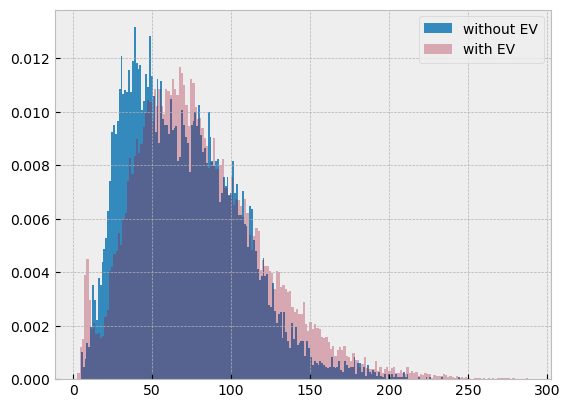

In [77]:
plt.hist(X[target_name][X["ev"] == 0], label="without EV", alpha=1, bins = 200, density=True)
plt.hist(X[target_name][X["ev"] == 1], label="with EV", alpha=0.3, bins = 200, density=True)
plt.legend()
plt.show()

## Multivariate EDA

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

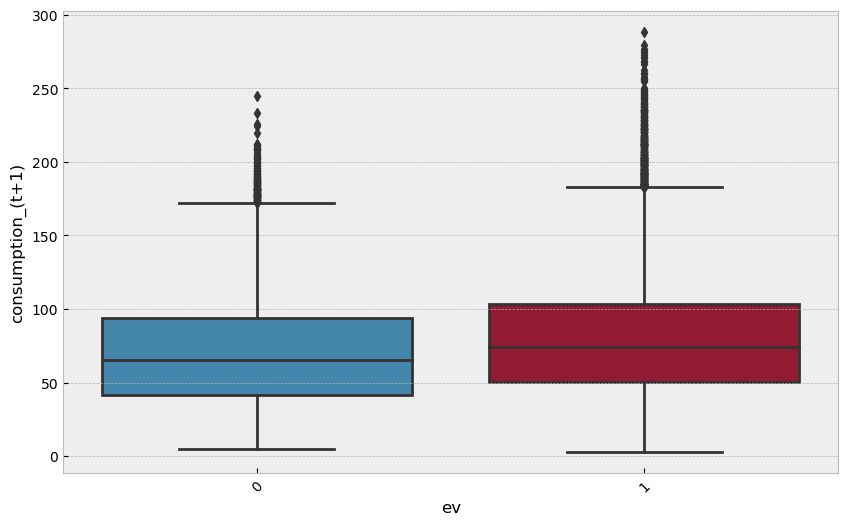

In [78]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='ev', y=target_name, data=X)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.show()

In [79]:
stats.ttest_ind(X[target_name][X["ev"] == 0],
                X[target_name][X["ev"] == 1],
                equal_var=False,
                alternative="less")

Ttest_indResult(statistic=-23.90462632955104, pvalue=2.5030140724594276e-125)

In [80]:
features_to_analyse = ['consumption_(t-1)', 'avg_temperature',
       'min_temperature', 'max_temperature', 'spread_temperature',
       'avg_humidity', 'min_humidity', 'max_humidity', 'spread_humidity',
       'avg_cloudiness', 'min_cloudiness', 'max_cloudiness',
       'spread_cloudiness']

In [81]:
# is slow
# sns.pairplot(X[['consumption_(t-1)',"avg_temperature", "avg_humidity", "avg_cloudiness"]])

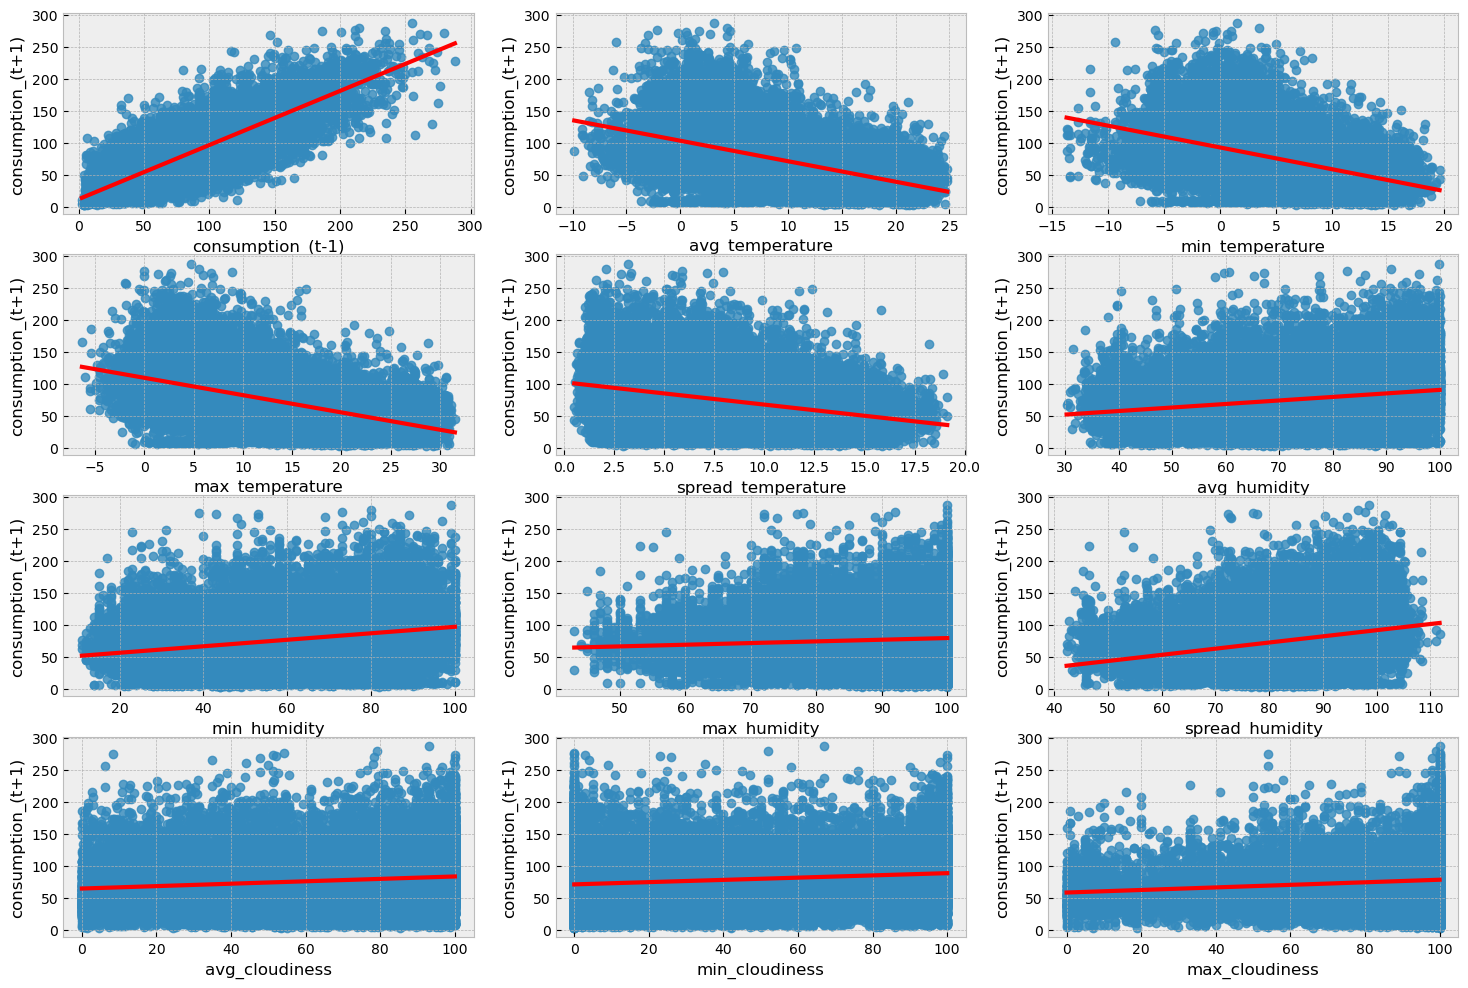

In [82]:
# Understand Linear relationship in between target vs features/ Note for lr y-will needed ot be transformed
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],
                    y=target_name,
                    data=X,
                    ax=ax,
                    ci=95,
                    line_kws={"color": "red"},
                    scatter=True,
                    fit_reg=True,
                    n_boot=100)

<AxesSubplot:>

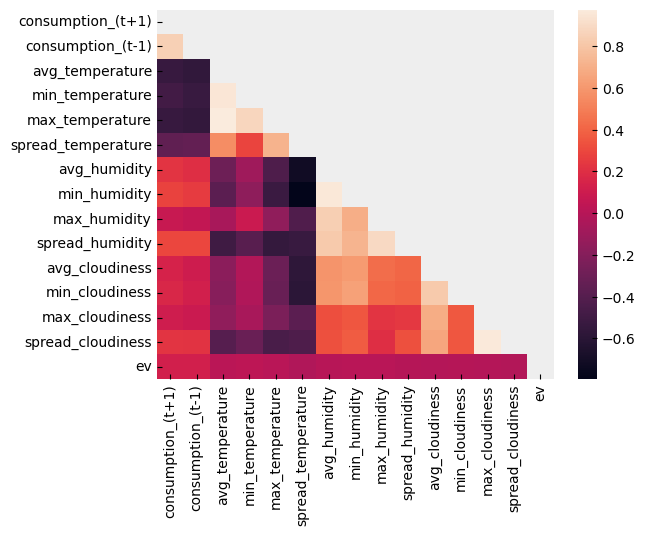

In [83]:
corr = X.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)

<AxesSubplot:>

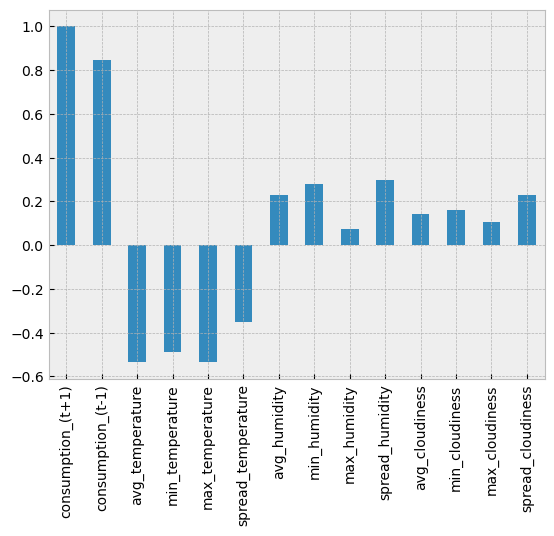

In [85]:
corr = X.corr(method='pearson')
corr[target_name].iloc[:-1].plot.bar()

# Portfolio EDA

In [86]:
portfolio_consumition = full_data[target_name].reset_index().groupby("agg_index").sum()

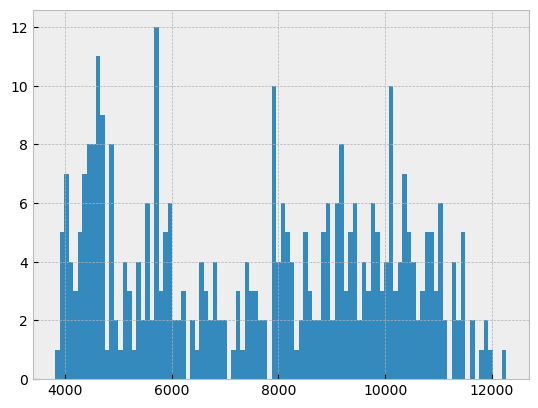

In [87]:
plt.hist(portfolio_consumition, bins= 100)
plt.show()

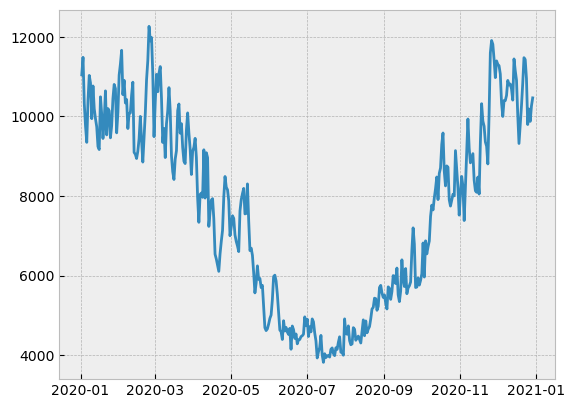

In [88]:
plt.plot(portfolio_consumition)

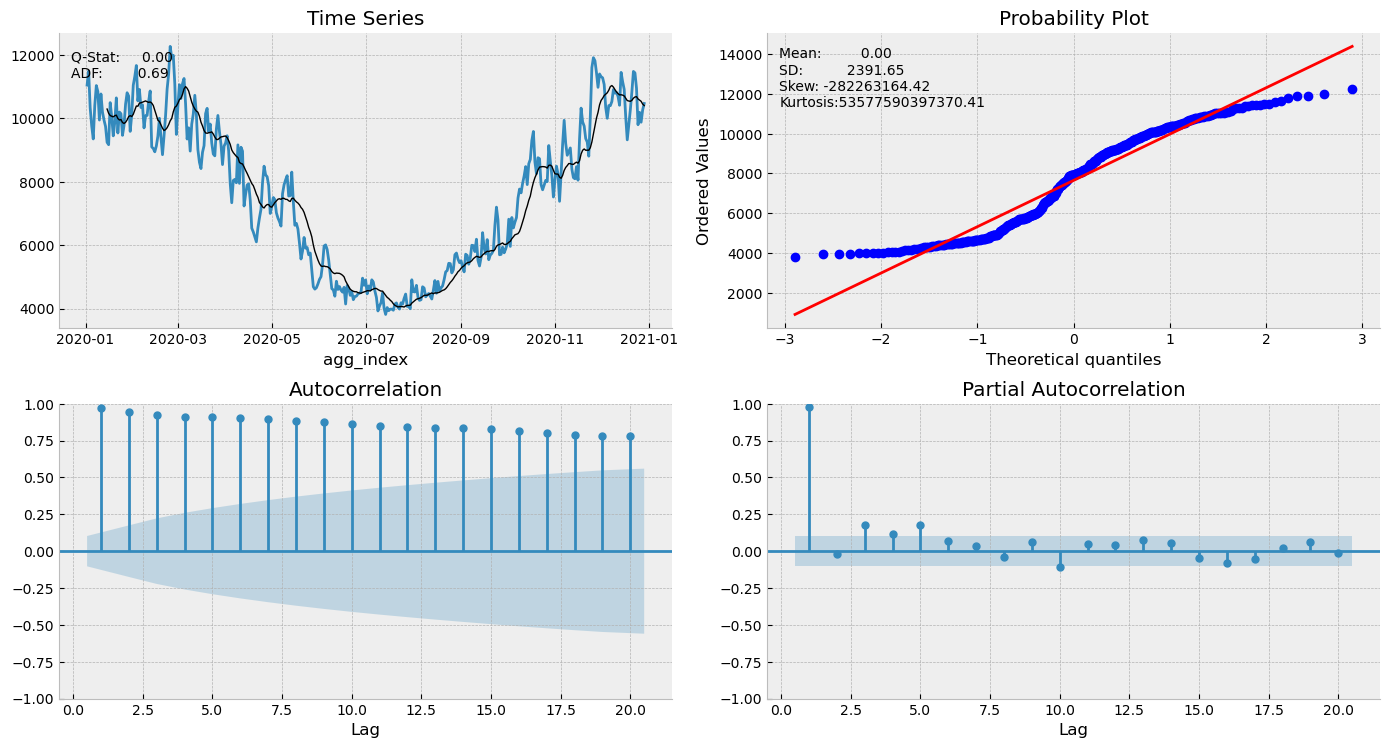

In [89]:
plot_correlogram(portfolio_consumition["consumption_(t+1)"], lags = 20)

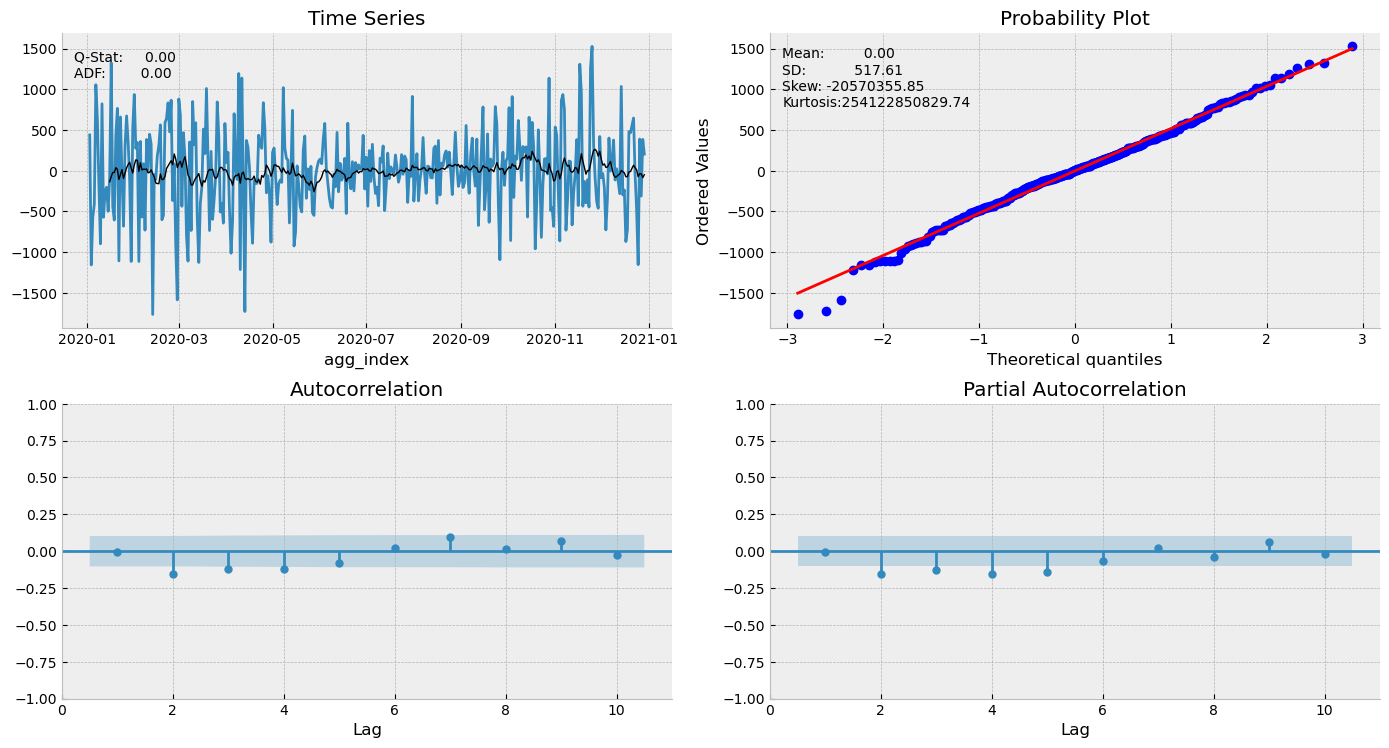

In [90]:
#on difference
plot_correlogram(portfolio_consumition["consumption_(t+1)"].diff().dropna())

## Outlier Detection
At the current stage there is no guarantee, that
data comes from single location, thus it might require to cluster or drop anomalies, the 
feature temperature could help us to estimate it (different Locations)

In [91]:
def get_difference_score(data):
    """
    Compare mean abs difference in between the current samples vs rest
    """
    dict_scores = {}
    for house_num in data.columns:
        avg = data[[col for col in data.columns if col !=  house_num]].mean(axis=1)
        dict_scores[int(house_num)] = np.mean(np.abs(data[house_num] - avg))
    return dict(sorted(dict_scores.items(), key=lambda item: item[1]))

### Temperature

<AxesSubplot:xlabel='agg_index'>

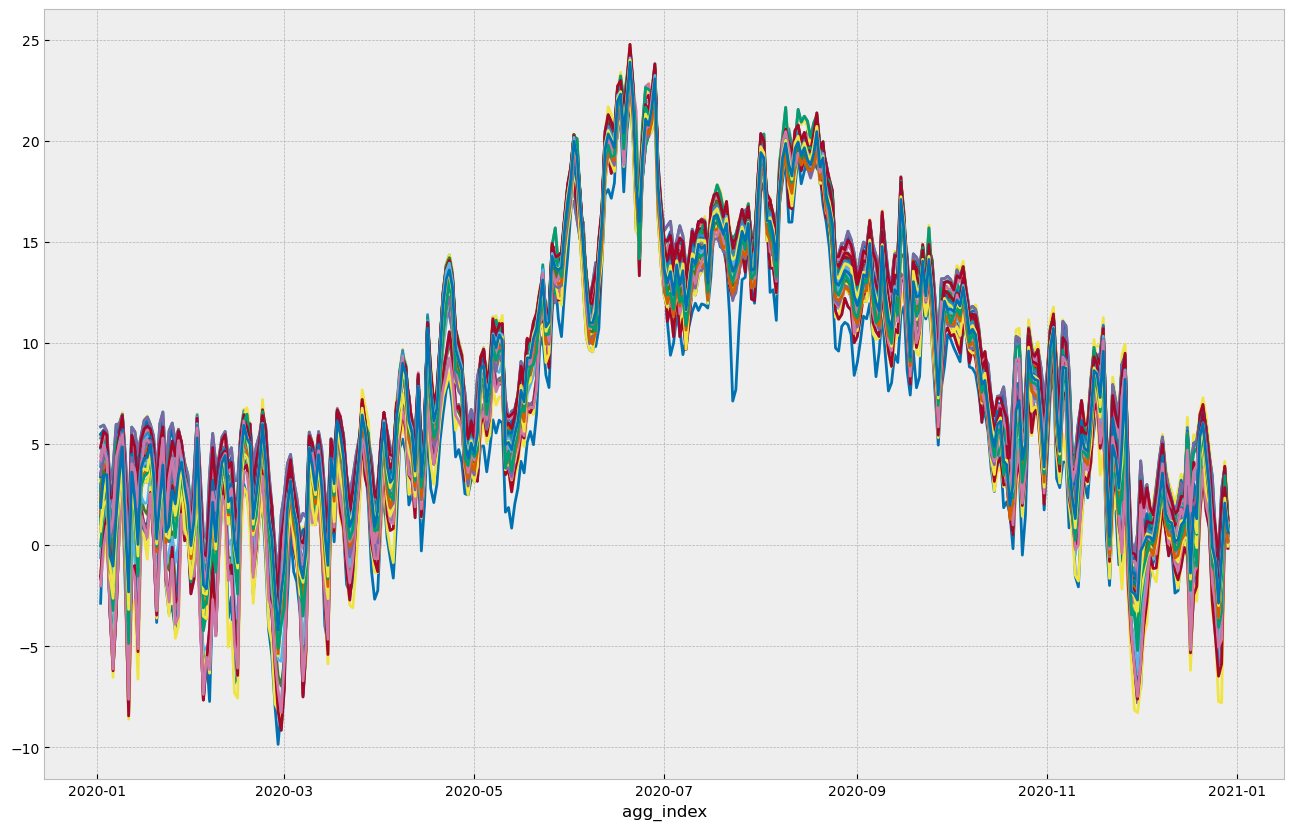

In [92]:
df_temp_per_house = pd.pivot_table(full_data[["avg_temperature","home_num"]].reset_index(),
                                   index="agg_index",
                                   values="avg_temperature",
                                   columns="home_num")

df_temp_per_house.plot(figsize=(16, 10), legend=False)

In [27]:
# get_difference_score(df_temp_per_house)

### Electricity Consumption

<AxesSubplot:xlabel='agg_index'>

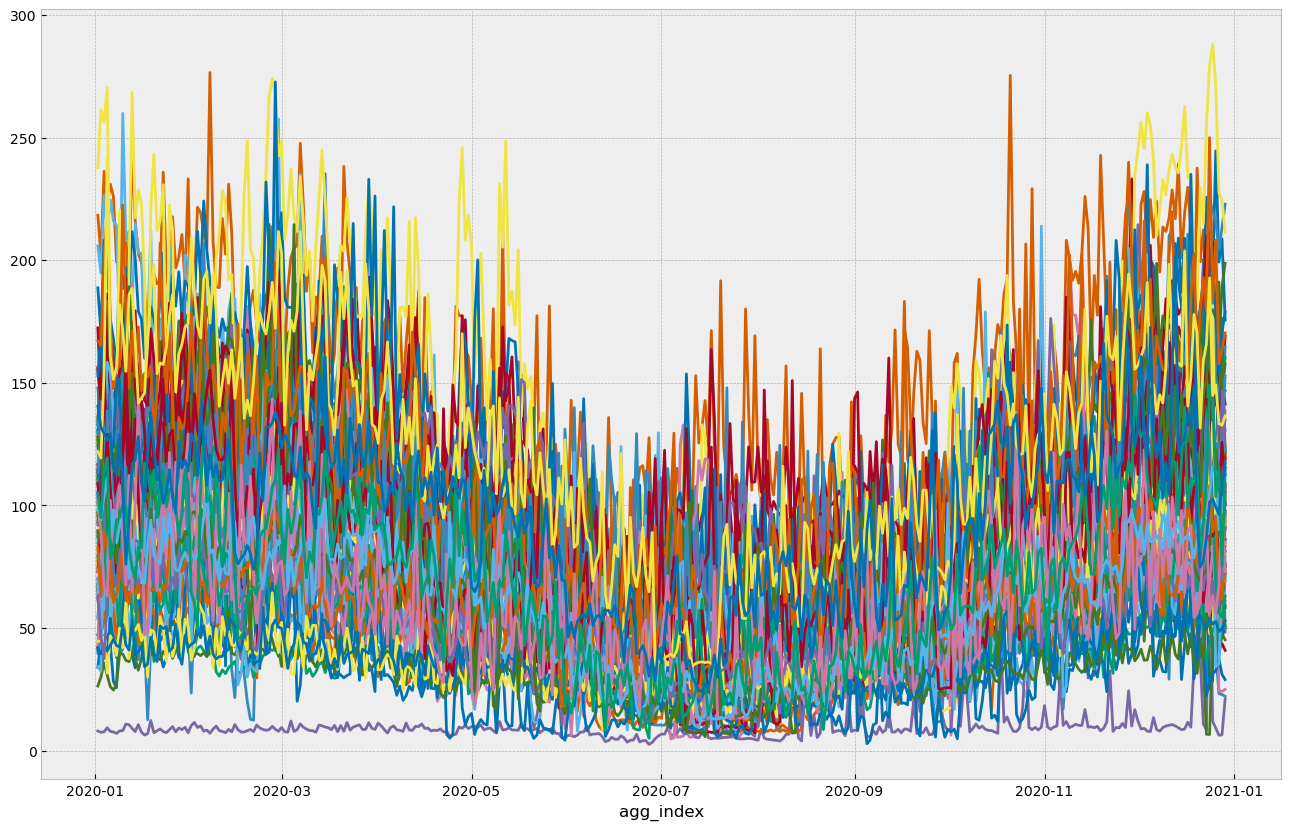

In [93]:
df_consumption_per_house = pd.pivot_table(full_data[["consumption_(t-1)","home_num"]].reset_index(),
                                   index="agg_index",
                                   values="consumption_(t-1)",
                                   columns="home_num")

df_consumption_per_house.plot(figsize=(16, 10), legend=False)

the purple line (268) seems to have quite low consmption and more les flat over time

In [29]:
# get_difference_score(df_consumption_per_house)

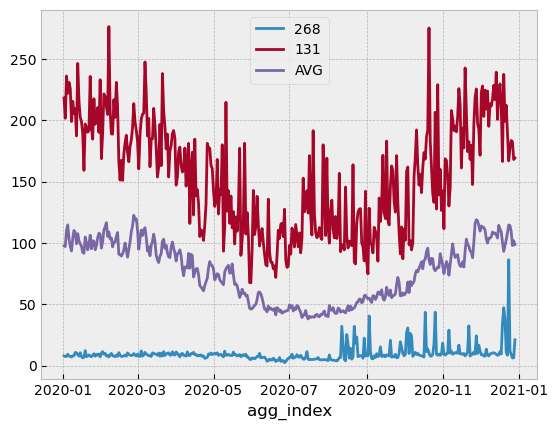

In [94]:
df_consumption_per_house[["268","131"]].plot()
df_consumption_per_house.mean(axis=1).plot(label="AVG")
plt.legend()

## NEXT STEPS
1) Formalize Fetuare Engineering
2) Get rid of anomaly home number 268
3) Try two modelling aproaches:
4) predict consumption for each hour directly
5) or predict consumption on daily basis and apply weighting function over 24 hour cycle (weighting function could be daily Seasonal ARIMA build in on data without yeatly seasonal(fall, winter, spring, summer) component
6) for train data we will use random sample of houses
7) we will use time-series cross-validation technique for each fold we will add previous data (thus we will get learning curve for free)